# Biweekly Report 4
# Jacob Tiede
## Exploring an Unsupervised Method of Image to Image Translation
To kick off this report I want to summarize a paper that I found recently that does what I thought was impossible: performs image to image translations without domain labels. My main goal with this paper is to learn the many techniques required to implement this, but given that my computer is not that powerful I doubt I will be able to replicate their results. This paper goes by the name High-Resolution Daytime Translation Without Domain Labels, and can be found here: https://arxiv.org/pdf/2003.08791.pdf. To start, what does it mean to not have domain labels? This is best described by the task of translating images from one time in the day to another. In other words, we would like to take an image and adjust the lighting so that it is a different time of the day. The subtlety here is that the authors would like to do this without domain labels, so our images have no meta-data to tell us what time of the day they were taken. To do this seems impossible, how can we gauge how well we are doing without knowing what we're supposed to model? The answer to this is by employing several losses all of which will accomplish different parts of this task. To start we will need to decompose this problem slightly into more manageable subproblems.
### Decomposing Images into Style and Content Representations
In prior works it has been noted that images contain two sorts of representations: the content of the image and the style that those images are in. This is similar to the work I did last week if one thinks of the content as what is learned by the L1 loss, and the style as when it is learned by the patch based discriminator. This is similar to what we are doing with style and content, but it is a little less explicit in how we extract these properties. In this article: https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398 it is said that a neural network trained for classification actually learns these representations as a sort of necissary step toward minimizing classification error. This is because of the way convolutions work. Consider a convolutional layer at the beginning of a network. Each node (or pixel) in the output of the convolution will only be dependent on a small subset of the input's pixels, meaning that learning high level structures (the content of the image) is impossible, but what is possible is learning things like average line thickness, typical line directions, and the low level shapes that are present in the image (the "style" of the image). As one moves deeper the representation can get more complex (more content is in each filter of the convolution). So, a way to extract style and content from an image would be to take a pretrained neural net like VGG or some other large classifier, and observe the filters at layers in the beginning of the network, and layers deeper in (to get the style and content respectively). I am abstracting some details here, namely the way that the losses must be adjusted to actually perform style transfer, but for the purposes of the paper of interest we don't need those details. The point is that style and content can be numerically and meaningfully extracted from images.
### Architecture Highlights
One of the central themes of this paper is the so-called HiDT architecture. This is an encoder decoder scheme where the encoder will extract the style of an image (output as a vector) and the content (output as a tensor) separately. The decoder's job is then to generate a new image using the content and style outputs from the encoder. These need not be from the same image, so after an image is decomposed by the encoder into style and content the decoder could use style from another image with the content from the original image, and it should give some output with the same overall structures as the original image, but with the lighting (style) of another image. We will again see a U-net like architecture, but with so called AdaIN connections to compose the style and content into a single tensor for the input of the decoder. This is worth going into more depth since it is such and important part of the architecture of this neural net:
#### Aside: AdaIN
For this section I will use this blog post as a guide https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431 to better understand of how AdaIN connections are applied. This article summarizes a paper from NVIDIA that introduces a new way of using GANs called styleGAN. Without any of the details this network seeks to give users the ability to regulate specific features of the output, like hair style, color, etc. Again, without going into too much detail it does this by trying to isolate entwined features of the input (meaning features that are correlated with one another from raw image data, for instance it might be hard to discern hair color from hair style only given the raw input data) using another neural network that outputs a tensor of the same size as the input (the 'latent' code). It then has a way of telling the generator how to use this information (i.e. a translation step) in the form of AdaIN. AdaIN stands for Adaptive Instance Normalization and serves the function of injecting information into the generator of styleGAN. It does this by applying instance normalization (normalizing all the channels of a convolutional output), then using another fully connected layer as the output of the fully connected neural network ($w$ in the article, this is a transform of the so-called 'latent' code) to scale and a bias is learned for this normalized output.  
 
This is an interesting approach since it is not necessarily intuitive to normalize an instance of an image, but it turns out that it allows us to have more control over generation of images. For more details I will now turn to the original AdaIN paper: https://arxiv.org/pdf/1703.06868.pdf. This gives a long history of style transfer, where it details that elements of style can be encapsulated by convolutional feature statistics (like the channel-wise mean, or the standard deviation), so it follows logically that manipulating these statistics could change the style of an image. AdaIN is simply a way of leveraging this by using two inputs: a content input (which will be manipulated) and a style input (which will do the manipulation). In an AdaIN layer we first normalize an image spatially (effectively removing the style, but retaining the content), then we simply multiply that by the standard deviation of the style input and add the mean of the style. This effectively changes the statistics of the image to retain the content, but have a style of another image.  
 
This seems exactly like what NVIDIA wanted to do with this network, rescaling a normalized image to have the 'style' that only relies on a 'code's' statistics. This is effectively how we can control the features of the final image, because this style code is related to what features we tell the neural net we want in the output.  
 
To summarize, AdaIN gives us a controlled way of injecting "style" into any layer of a neural net, effectively allowing the style transfer to take place anywhere within the neural net through clever use of summary statistics. In NVIDIA's case they use this at every layer of the GAN to make sure a chosen style propagates all the way through their GAN, and our case uses the technique as well to inject style into the decoder part of network (which should make sense since our encoder is isolating the content of the image, and we need to inject the style of another image into it, which is the decoder's job). These AdaIN connections are put in each of the U-net connections of the encoder-decoder architecture of our model. Now, we can talk about the specific structure of a HiDT block.
#### Structure of HiDT Blocks
In this section I will not get into the flow of information through the model (since that will require a discussion on the losses that were applied, which will require its own section), just the general structure of a single encoder decoder for the basics of how the dimensions change as we move through the model. To start we should clarify one aspect of the encoder: there will actually be two different kinds of encoders. Using the notation from the paper we have one encoder $E_c$ that takes in an image and outputs a tensor that represents the content, and another encoder $E_s$ that takes an image as input and outputs a vector representing the style.  
 
The architecture of the encoders themselves seems close to what you would expect, $E_c$ is composed of convolutional and downsampling layers with residual connections, eventually resulting in a tensor as the output (so no flattening at the end). It works with 2 downsampling layers, and 4 residual blocks, though they only allow five channels to flow through the residual connections (they mention that they would like to limit the amount of information that can flow through the skip connection as it produces better results). $E_s$ on the other hand is a purely convolutional network that makes use of stride to downsample. After 3 bouts of downsampling (convolutions) we will use an adaptive average pool and a 1x1 convolution to make our vector into a length 3 vector representing the style.  
 
The decoder mirrors the content encoder's architecture using transposed convolutions (though it has 5 residual blocks) in order to form a valid U-net structure. At each of the connections between $E_c$ and the decoder we will inject style (note: this style is not necessarily from the same image as the content) using an AdaIN connection. Now that we have a general idea of the structure we can talk about the flow of information through the net and what losses we will use:
#### Flow of Information Through HiDT
For this section I want to keep this figure from the paper in mind:   
![alt text](Figure3FromPaper.JPG "Title")  
I'll define everything as we go, but this is a great picture for how the loss will work.  
 
To start, it is important to note that the decoder (in the generator) will actually give two outputs, one as an image output and one as a segmentation mask. By providing a segmentation mask the authors can compare the segmentations of the original image to the segmentations of the output, which provides them with the ability to control the style transfer (in fact if they don't do this they find that grass can turn into water in the output). The "ground truth" segmentation is actually provided by a pretrained model that can effectively segment landscape images. To make this explicit (using the notation from the paper) if our content encoder $E_c$ can take an image and output a code representing the content $c$ and if $E_s$ can output a code representing the style of an image $s$ then the decoder takes $c$ and $s$ and outputs a new image $\hat{x}$ and a segmentation mask $\hat{m}$. To determine the ground truth of the segmentation mask we simply employ a pre trained neural network designed to segment images.  
 
There is yet more complexity added to this because we will consider a plethora of losses, but first we will consider the broad idea of what we are trying to accomplish. Consider taking two images from our data, each without any labels to indicate what time of day these pictures were taken. This means that we don't necessarily know which image we should use as the style image and which we should use as the content, so the model solves this by having two symmetric portions, one that uses image $x_1$ as the style and one that uses image $x_1$ as the content. It is then sufficient to talk about only one of these halves of the network, but know that for every pair of images fed to the network there are actually two symmetric networks at play, each of which is treating one of the images as the style and one as the content. Now, we will consider how we train one half of this network using an image $x$ as the content and an image $x'$ as style. To successfully transfer style we need to have several things be consistent, including ways to ensure our content/style encoders are generating the proper codes, something that tells the model how close or far we are from the original image (reconstruction loss), as well as so-called cycle consistency. I'll now go through this background information, starting with what type of GAN we will be employing: a least squares GAN:
#### Aside: Least Squares GANs:
For this section I will summarize the high points of https://machinelearningmastery.com/least-squares-generative-adversarial-network/ in order to understand what a least squares GAN is. To start, recall that the first use of GANs used a simple cross entropy loss to train both the discriminator and the generator. This is problematic, the article says, because we can run into problems with vanishing gradients due to the fact that this loss doesn't give the generator any idea how far it is from a correct response. Cross entropy can really only tell the generator if it fooled or if it did not fool the discriminator, but in the beginning of training the GAN is most likely very far from a reasonable solution, so it would benefit performance to have a way to tell the generator that it is very wrong, not just that it is wrong. A least squares GAN aims to solve this problem by changing the cross entropy loss into a least squares loss, thus giving the generator more information about how good or bad its generated images are. As a note: the least squares loss is just L2 loss (or MSE loss in pytorch). Now that we know what our GAN is like broadly speaking we can look more closely at what is meant by "cycle consistency".
#### Aside: Cycle Consistency
For this section I will summarize this blog post: https://towardsdatascience.com/a-gentle-introduction-to-cycle-consistent-adversarial-networks-6731c8424a87. The big subtilty in cycle GAN is that we won't be pairing a template to an expected output (like I did in my third biweekly report), rather we will have two collections of like classes (the example used in this blog is zebras as one collection of images, and horses as another collection of images) which have no direct pairing. Cycle GAN translates between these two domains by using what is called "cycle consistency" which is a new conception of loss. To make this explicit we will define our two classes (zebras and horses) as A and B respectively. We then have the goal of using some generator $G(x,z)$ (where $G$ is the generator, $x$ is the input template image, and $z$ is the noise vector) to take a vector from space A and translate it into space B (ie $A->G->B)$). However, there is nothing stopping us from using another generator to translate from B to A using a new generator (called $F$) $B->F->A$. Now, it might be starting to become apparent what we are trying to do here. We have to train two GANs in order to do this effectively, because the data is not paired. First we take an image from the input space A and pass it through G which will attempt to generate an image in the target space B. Since we have no way to give a discriminator a real image to compare this image to we will have to do something clever. We will use F to translate the generated image back to the input space A. Now we have both a real image (the original input) and a fake image (generated using F), which we can use to train a discriminator that I will call Da. This will simultaneously train G, F and Da, but one can see the problem if we were to stop here. G will generate some tensor that needs to be translated back by F, there is nothing telling G to generate a tensor that actually looks like the image, just something that F understands and can translate. The first step to enforcing that G is actually drawing the correct object is to do this same training, but using images from B as the input. This means that we will have one step where we have a pipeline that looks like this:  
 
A -> G -> B -> F -> A -> adversarial loss  
 
and one phase that looks like this:  
 
B -> F -> A -> G -> B -> adversarial loss  
 
However, this still doesn't quite give the results we are looking for. To attain good results we can recognize that we should, in theory, be generating the same images after passing the original template through both of the generators. This means that we can minimize the distance between the retranslated images and original images at each step as well (this is the cycle consistency loss). Below I've drawn a picture since I think many of the pictures online fail to capture all of these aspects:  
![alt text](CycleGAN.JPG "Title")  
This actually only shows half of the cycle GAN, but the other half is just using an image from B as the input, but the idea is the same. One can see why this particular neural architecture is applied here, since really our model is just taking this sort of idea one step further. Rather than having data separated into two spaces A and B we only have one group. This is certainly a good starting point, but the authors of the paper need to make use of many subtle tweaks in order for this to work, the first one is the use of a so-called projection discriminator.
#### Aside: Projection Discriminator
For this section I will review the original paper on projection discriminators which can be found here: https://arxiv.org/pdf/1802.05637.pdf. The main point that a projection discriminator is trying to address is the concatenate step in cGANs. In most cGANs the template and a real/fake image are simply concatenated channelwise as they are fed into the discriminator. Projection discriminator seeks to leverage statistical assumptions to make the incorporation of this knowledge more robust in our model. Perhaps the best description of this method comes from section 3 of the paper where the authors state that: "our discriminator measures the divergence between the generator distribution p and the target distribution q on the assumption that p(y|x) and q(y|x) are relatively simple". To translate this into slightly more explicit terms, we are dealing with two probabilistic distributions, a target distribution q (the distribution that our GAN is trying to learn) and the distribution that our generator is outputting at this step in time p. By assuming that the conditional distributions of p and q (conditioned on some input template image) are relatively simple, the authors give a way of measuring how far the current distribution of the generator is from the target distribution. To make this idea salient we will consider figure 1 from the paper:  
![alt text](Figure1Projection.JPG "Title")  
We can see that this new model doesn't make use of any concatenation, which was the goal. Let me quickly explain the flow of information here, first we take a generated image x and feed it through a neural net $\phi$ which produces an output that will be both fed through another neural net $\psi$ and an "inner product" operation. Both of these outputs are then summed to produce the output of the discriminator. Everything here should be clear, except for the inner-product step. This can be written as: $y^TV\phi(x)$ where $y$ is the template, $x$ is the image we are classifying as real or not real, and $V$ is an embedding matrix which will be learned in training. This is really what is important to know for our application, and for getting this code to work I will use this github as a reference: https://github.com/MingtaoGuo/sngan_projection_TensorFlow. The last bit of prerequisite knowledge we will need is what CORAL loss is in this context.
#### Aside: CORAL Loss
For this section I will be summarizing the original paper that introduces this so-called CORAL approach: https://arxiv.org/pdf/1612.01939.pdf. First, let's describe the problem that CORAL seeks to solve: for most machine learning algorithms assumptions about the distribution of the training and testing data must be made. Namely, we assume that all of the training data are independently sampled from the same probabilistic distribution, and we assume that the test data also comes from this distribution. The authors state that this is rarely the case in real data, so they propose a potential solution by manipulating the data so the second order statistics are consistent. To accomplish this the authors define CORAL loss to be the distance between the covariance matrix of the model's output using a training image as the input, and the model's output using an image from the test set. This loss (the distance between covariance matrices) can also be defined and run for any intermediate layer of the network, so you can work to have second order statistics align between training and test set in any step of the model. To get this loss we actually have to do two passes through the model, figure 5 from the paper illustrates this quite well, and I've attached it below:  
![alt text](Figure5CORAL.JPG "Title")  
I won't get into the details for how this works here, but in my implementation I'll speak more about the specifics of this approach within the context of the original paper.
#### Back to Flow of Information Through HiDT
Now that we've gotten all the necessary background the natural question is: how is all of this adapted and used in our particular application. To start, I will again point to figure 3 from the paper (to reiterate the source: https://arxiv.org/pdf/2003.08791.pdf) which I attached in this document (back in the Flow of information through HiDT section, and copied here for convenience). This provides us with an excellent visual overview which I will attempt to explain in words. First I will enumerate the goals of our neural network.  
![alt text](Figure3FromPaper.JPG "Title")  
It is important not to lose sight over what we are doing as a whole: taking two images from a single set of images (with no labels at all) and translating one from day to night (or vise-versa). As such our overall goal is to take image 1, decompose it to style and content, then generate a new image with the same content but different style. An integral part of this step is the decomposition of style and content using our encoders $E_s$ and $E_c$ respectively. This means that it would be advantageous to incorporate a loss that makes sure that $E_s$ and $E_c$ are both doing their jobs. This is where we use $\mathcal{L}_c$, $\mathcal{L}_s$, $\mathcal{L}^r_c$, and $\mathcal{L}^r_c$. Referring to figure 3 from the paper, you can see that all of these losses appear after we have taken a "known" style vector, and a "known" content code and fed them to the generator, which produced some images. This generated image is then fed through $E_s$ and $E_c$ again, but since our generator's job is simply to make an image with given style and content codes we know that, given a perfect generator, these two codes should be extracted by $E_c$ and $E_s$ exactly as they were before we passed them through the generator, and any difference between codes would be considered a mistake. This means that all four of those losses represent the L1 distance measure of the code we see after we generate an image and the expected codes (what was passed to the generator). NOTE: $s_r$ is just a random vector sampled for the space of possible style codes (i.e. it is random with the same dimension as $E_s$'s output). Also note that $s'$ is the style extracted from another image in the dataset. Also remember that there are two symmetric setups running at the same time similar to our discussion on cycle consistency (in fact the losses we just discussed enforce cycle consistency in the encoders).  
 
Now that we have a loss that helps our encoders run smoothly we can turn to ensuring the content is carried through the model. This comes in the form of image reconstruction losses: $\mathcal{L}_{rec}$, $\mathcal{L}_{cyc}$, and $\mathcal{L}^r_{rec}$. This will take the output of the generator and compare it to the original input of the model. To make this clear using the notation from the figure above and the paper: $\mathcal{L}_{rec} = ||\tilde{x} - x||_1$, $\mathcal{L}_{cyc} = ||\tilde{\hat{x}} - x||_1$, and $\mathcal{L}^r_{rec} = ||\tilde{x_r} - x_r||_1$. This will help enforce that the content is correct in the generated image. Next let's talk about CORAL fits into this model.  
 
This loss is labeled $\mathcal{L}_{dist}$ on the figure, and works by collecting $T$ styles from past mini batches and applying a stop gradient option. This previous set of styles is called $[s^{(1)}, s^{(2)},..., s^{(T)}]$. We then add $s$ and $s'$ to this pool (these are kept in the computational graph) and calculate the mean and covariance matrix of this pool and make the loss try to enforce that these come from a standard normal. Making this explicit with notation from the paper: $\mathcal{L}_{dist} = ||\hat{\mu}_T||_1 + ||\hat{\Sigma}_T-I||_1 + ||diagonal(\hat{\Sigma}_T - 1||_1$ where $\hat{\mu}_T$ is the mean of our pool of styles (after appending the two styles currently a part of the computational graph), and $\hat{\Sigma}_T$ is the covariance matrix. This will enforce that our styles are all a part of a standard normal distribution (using the CORAL approach we briefly discussed). Finally, there is an adversarial loss that we have yet to discuss.  
 
This loss has been omitted from the figure from the paper, but with our discussion on least squares GANs, and cycle consistency we should be able to figure out where these are. We will apply adversarial loss to each of the generated images (except the reconstructed input), and this will use both a projection discriminator (conditioned with the style vector that we input to the generator), and an unconditioned discriminator. Each of these will be applied to all generated images including the ones generated with a random style. There are still other details here, but in the interest of making this report slightly shorter (since those details are relatively minor) I will omit those details. We can now begin to code this project:


### Implementation
The only thing I want to note about the implementation before I start is that I do not plan to use the segmentation loss right now. This model seems difficult enough for my computer to run, and adding another large model to my graphics card's memory seems infeasible now. Depending on the run time and GPU usage of this implementation I will consider implementing the segmentation loss.
#### Implementing the Encoder/Decoder
To start, recall that these will require AdaIn connections in order to function, so we'll start with implementing that:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
import os
import matplotlib.pyplot as plt
import progressbar #If you're missing this library it is found here: https://pypi.org/project/progressbar2/
print("Is a GPU available? ")
torch.cuda.is_available()

Is a GPU available? 


True

In [2]:
"""
AdaIN - defines an adaptive instance normalization block as described in https://arxiv.org/pdf/1703.06868.pdf

@params - x: The tensor representing the content
        - y: The style vector
"""
def AdaIN(x,y):
    #x should have shape (batch_size, channels, H, W)
    mu_x = torch.mean(x, dim = 1).view(x.shape[0], 1, x.shape[2], x.shape[3]) 
    sigma_x = .00001 + torch.std(x, dim = 1).view(x.shape[0], 1, x.shape[2], x.shape[3]) 
    
    #y should have dimension (batch_size, D) D will be 3 in our case
    mu_y = torch.mean(y, dim = 1).view(y.shape[0], 1, 1, 1) #has dim (batch_size,1,1,1)
    sigma_y = .00001 + torch.std(y, dim = 1).view(y.shape[0], 1, 1, 1) #has dim (batch_size,1,1,1)
    #Do this for similar reasons as we did in ghost batch norm, without chunking we will run into problems with backprop
    chunks = torch.chunk(x, x.shape[1], dim = 1)
    output = []
    i = 0
    for j in chunks:
        #I put the slices here (pointlessly) to make the code clearer to myself (it helped me visualize the dimensions)
        output.append(((j[:,:,:,:] - mu_x[:,:,:,:])/sigma_x[:,:,:,:]))
        i+=1
    for j in range(x.shape[1]):
        output[j] = (sigma_y[:,:,:,:]*output[j][:,:,:,:] + mu_y[:,:,:,:]).view(x.shape[0],1,x.shape[2],x.shape[3])
    res =  torch.cat(output, dim=1)
    return res
test_x = torch.rand(1,3,2,2).cuda()
test_y = torch.rand(1, 3).cuda()
ada = AdaIN(test_x, test_y)
print(ada.shape)
#verify statistics:
print("Is the mean of ada equal to the mean of the imparted style?")
means = torch.mean(ada, dim = 1)
print("Means per channel:")
print(means)
print("Expected Means:")
print(torch.mean(test_y, dim = 1))
print("Is the standard deviation equal to the imparted style?")
stds = torch.std(ada, dim =1)
print("Standard dev per channel:")
print(stds)
print("Expected standard dev:")
print(torch.std(test_y, dim = 1))

torch.Size([1, 3, 2, 2])
Is the mean of ada equal to the mean of the imparted style?
Means per channel:
tensor([[[0.8162, 0.8162],
         [0.8162, 0.8162]]], device='cuda:0')
Expected Means:
tensor([0.8162], device='cuda:0')
Is the standard deviation equal to the imparted style?
Standard dev per channel:
tensor([[[0.0438, 0.0438],
         [0.0438, 0.0438]]], device='cuda:0')
Expected standard dev:
tensor([0.0438], device='cuda:0')


Looks like the adaptive instance normalization is working, now we can define the encoders. The paper states that "the content encoder has two downsampling and four residual blocks; after each downsampling, only five channels are used for skip connections in order to limit the information flow through them", and for the decoder the paper states: "The style encoder contains four down-sampling blocks. The output of the style encoder is a three-channel tensor, which is averaged-pooled into a three dimensional vector". This should be straightforward to implement, but we do need to keep the U-net skip connections in mind when creating the encoder classes. 

In [3]:
"""
E_c - defines a content encoder as described by https://arxiv.org/pdf/2003.08791.pdf

@params - n_in: the number of input channels
        - n_out: the number of output channels of each block
        - n_propagate: the number of channels that are propagated through the skip connections
        - n_layers: the number of residual layers before each downsampling operation
        - n_downSample: The number of downsampling operations we do

@methods: getSavedLayers(self): returns a list of the layers that we saved (for the U-net part of the generator)
"""
class E_c(nn.Module):
    def __init__(self, n_in, n_out, n_propagate = 5, n_layers = 4, n_downSample = 2):
        super(E_c, self).__init__()
        self.n_in = n_in 
        self.n_out = n_out
        self.n_layers = n_layers
        self.n_propagate = n_propagate
        self.n_downSample = n_downSample
        self.savedLayers = []
        
        self.layers = nn.ModuleList([])
        self.downSampleLayers = nn.ModuleList([])
        self.relu = nn.ReLU()
        for j in range(self.n_downSample + 1):
            for i in range(self.n_layers):
                if i == 0:
                    if j == 0:
                        self.layers.append(nn.Conv2d(self.n_in, self.n_out, 3, padding = 1))
                    else:
                        self.layers.append(nn.Conv2d(self.n_out, self.n_out, 3, padding = 1))
                    self.layers.append(nn.BatchNorm2d(self.n_out))
                else:
                    self.layers.append(nn.Conv2d(self.n_out+self.n_propagate, n_out, 3, padding = 1))
                    self.layers.append(nn.BatchNorm2d(self.n_out))
            if j != self.n_downSample:
                self.downSampleLayers.append(nn.Conv2d(self.n_out, self.n_out, 4, stride = 2, padding = 1))
                
    def forward(self, x):
        self.savedLayers = []
        for j in range(self.n_downSample+1):
            for i in range(self.n_layers):
                if i != 0:
                    #I'm cating here since we are only propogating 5 of the channels, and this seemed like a more plausable interpretation of the paper than
                    #just addition
                    x = torch.cat((x, x_mem), dim = 1)
                x = self.relu(self.layers[2*(i+j*(self.n_layers))](x))
                x = self.layers[2*(i+j*(self.n_layers))+1](x)
                x_mem = x[:, 0:self.n_propagate, :, :].clone()
            if j != self.n_downSample:
                self.savedLayers.append(x.clone())
                x = self.downSampleLayers[j](x)
        return x
    
    def getSavedLayers(self):
        return self.savedLayers

"""
E_s - defines a style encoder as described in https://arxiv.org/pdf/2003.08791.pdf

@params - n_in: the number of input channels
        - n_out: the number of output channels of each block
        - n_downSample: The number of downsampling operations we do
        - imageResolution: all images should be square and image resulution = n if each image is nxn

"""
class E_s(nn.Module):
    def __init__(self, n_in, n_out, n_downSample = 4, imageResolution = 256):
        super(E_s, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.n_downSample = n_downSample
        self.imageResolution = imageResolution
        
        self.relu = nn.LeakyReLU(.2)
        self.layers = nn.ModuleList([])
        for i in range(self.n_downSample):
            if i == 0:
                self.layers.append(nn.Conv2d(self.n_in, self.n_out, 4, stride = 2, padding = 1))
            elif i == self.n_downSample-1:
                self.layers.append(nn.Conv2d(self.n_out, self.n_out, 4, stride = 2, padding = 1))
            else:
                self.layers.append(nn.Conv2d(self.n_out, self.n_out, 4, stride = 2, padding = 1))
        self.globalPool = nn.AdaptiveAvgPool2d(1)
        self.fConv = nn.Conv2d(self.n_out, 3, 1)
    def forward(self, x):
        for i in range(self.n_downSample):
            x = self.relu(self.layers[i](x))
        x = self.fConv(self.globalPool(x))
        
        return x

Now we can implement the decoder (generator). From the paper: "The decoder has five residual blocks with AdaIN layers and two upsampling blocks.  AdaIN parameters are computed from the style vector via three-layer fully-connected network":

In [4]:
"""
ResBlock - Define a residual block to be used in the Generator, note: these are addition res blocks (not concatination like E_c)

@params - n_in: the number of channels being fed into the ResBlock
        - n_out: the number of output channels of each convolution
        - n_layers: the number of layers in the resnet structure
"""
class ResBlock(nn.Module):
    def __init__(self, n_in, n_out, n_layers = 5):
        super(ResBlock, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.n_layers = n_layers
        
        self.convLayers = nn.ModuleList([])
        self.BNLayers = nn.ModuleList([])
        self.relu = nn.ReLU()
        self.convLayers.append(nn.Conv2d(self.n_in, self.n_out, 3, padding = 1))
        self.BNLayers.append(nn.BatchNorm2d(self.n_out))
        for i in range(self.n_layers-1):
            self.convLayers.append(nn.Conv2d(self.n_out, self.n_out, 3, padding = 1))
            self.BNLayers.append(nn.BatchNorm2d(self.n_out))
    def forward(self, x):
        for i in range(self.n_layers):
            if i != 0:
                x = x + x_mem
            x = self.BNLayers[i](self.relu(self.convLayers[i](x)))
            x_mem = x.clone()
        return x
"""
Generator - defines a generator as defined in https://arxiv.org/pdf/2003.08791.pdf

@params - n_in: the number of input channels
        - n_out: the number of output channels for each convolution (the # of output channels in the final conv will always be 3 to be a valid image)
@methods: setSavedLayers(self, x): sets the layers in the U-net skip connections from E_c
"""
class Generator(nn.Module):
    def __init__(self, n_in, n_out):
        super(Generator, self).__init__()
        self.skipLayers = None
        self.n_in = n_in
        self.n_out = n_out
        
        #style processing
        self.fc1 = nn.Linear(3,3)
        self.fc2 = nn.Linear(3,3)
        self.fc3 = nn.Linear(3,3)
        self.leReLU = nn.LeakyReLU(0)
        
        #upsampling/batchnorms
        self.upsample1 = nn.ConvTranspose2d(self.n_out, self.n_out, 4, stride = 2, padding = 1)
        self.BN1 = nn.BatchNorm2d(self.n_out)
        self.upsample2 = nn.ConvTranspose2d(self.n_out, self.n_out, 4, stride = 2, padding = 1)
        self.BN2 = nn.BatchNorm2d(self.n_out)
        
        #residual blocks
        #self.res1 = ResBlock(self.n_in, self.n_out)
        self.res2 = ResBlock(self.n_out*2, self.n_out)
        self.res3 = ResBlock(self.n_out*2, self.n_out)
        self.finalConv = nn.Conv2d(self.n_out, 3, 3, padding = 1)
        
    def forward(self, c, s):
        #find style s:
        s = self.leReLU(self.fc3(self.leReLU(self.fc2(self.leReLU(self.fc1(s))))))
        #create adain input:
        ada = AdaIN(c, s.clone())
        
        ada = self.BN1(self.leReLU(self.upsample1(ada)))
        
        #get the first skip connection, and merge its style with s using an adaIn connection
        skip1 = AdaIN(self.skipLayers[len(self.skipLayers) - 1], s)
        if skip1.shape[1] != ada.shape[1]:
            print("Skip connections of incorrect shape")
        #merge layers
        ada = torch.cat((ada, skip1), dim = 1)
        ada = self.res2(ada)
        ada = self.BN2(self.leReLU(self.upsample2(ada)))
        
        #same as above
        skip2 = AdaIN(self.skipLayers[len(self.skipLayers) - 2], s)
        if skip2.shape[1] != ada.shape[1]:
            print("Skip connections of incorrect shape")
        ada = torch.cat((ada, skip2), dim = 1)
        ada = self.res3(ada)
        #sigmoid to make each a valid image
        ada = torch.sigmoid(self.finalConv(ada))
        
        return ada
    def setSavedLayers(self, x):
        self.skipLayers = x
x = torch.rand(1,3,256,256).cuda()
es = E_s(3,64).cuda()
ec = E_c(3,64).cuda()
gen = Generator(64,64).cuda()

#test:
s = es(x).view(1,3)
c = ec(x)
gen.setSavedLayers(ec.getSavedLayers())
print("Output shape of generator:")
inp = gen(c,s)
print(inp.shape)
cirterion = nn.MSELoss()

#Test to make sure we can back propagate
loss = cirterion(inp, inp)
loss.backward()
torch.cuda.empty_cache() 
del(x)

Output shape of generator:
torch.Size([1, 3, 256, 256])


Now let's get to work on the projection discriminator. The paper actually mentions that it uses two discriminators (one conditional and the other not, this is also making use of "multi-scale" discriminators which just means each of these will discriminate at different resolutions, see https://arxiv.org/abs/1810.08534, this set-up is sort of U-net like (see https://medium.com/@animeshsk3/msg-gan-multi-scale-gradients-gan-ee2170f55d50), but the VRAM on my computer makes this infeasible, there just isn't anyway for me to save more instances of images, so I will have to forgo this implementation detail) and each is said to have "3 downsampling layers". Recall that the conditional GAN will be a so-called projection discriminator which I will make use of code from https://github.com/MingtaoGuo/sngan_projection_TensorFlow to help implement this.

In [5]:
"""
Discriminator - this defines a discriminator as defined by https://arxiv.org/pdf/2003.08791.pdf, but without the multi-scale implementation

@params - n_in: number of channels in
        - n_out: number of channels out
        - resolution: The resolution that each image is
@methods: setConditional(self,x): tell the network if it is the conditional discriminator or not
"""
from torch.nn.parameter import Parameter
class Discriminator(nn.Module):
    def __init__(self, n_in, n_out, resolution = 256):
        super(Discriminator, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.resolution = resolution
        self.conditional = True
        
        self.conv1 = nn.Conv2d(self.n_in, self.n_out, 4, stride = 2, padding = 1)
        self.BN1 = nn.BatchNorm2d(self.n_out)
        self.conv2 = nn.Conv2d(self.n_out, self.n_out, 4, stride = 2, padding = 1)
        self.BN2 = nn.BatchNorm2d(self.n_out)
        self.conv3 = nn.Conv2d(self.n_out, self.n_out, 4, stride = 2, padding = 1)
        self.BN3 = nn.BatchNorm2d(self.n_out)
        
        self.activation = nn.ReLU()
        self.globalpool = nn.AvgPool2d(int(self.resolution/8))
        self.fc1 = nn.Linear(self.n_out, 32)
        self.fc2 = nn.Linear(32, 1)
        #V is the learned matrix for conditional discriminators
        self.V = Parameter(torch.zeros(3,32))
        self.V = nn.init.xavier_uniform_(self.V)
        self.V = self.V
        
    def forward(self, x, s):
        x = self.BN1(self.activation(self.conv1(x)))
        x = self.BN2(self.activation(self.conv2(x)))
        x = self.BN3(self.activation(self.conv3(x)))
        
        
        x = self.globalpool(x)
        x = x.view(-1,self.n_out)
        
        x = self.activation(self.fc1(x))
        
        #project conditional info: (used https://github.com/MingtaoGuo/sngan_projection_TensorFlow as a guide)
        if self.conditional:
            
            temp = torch.matmul(s,self.V)
            temp = torch.sum(temp * x.clone(), dim=1)
            print(temp.shape)
        x = self.fc2(x)
        print(x.shape)
        if self.conditional:
            x = x + temp.view(x.shape)
            
        return x
    def setConditional(self,x):
        self.conditional = x

x = torch.rand(2,3,64,64).cuda()
es = E_s(3,64).cuda()
ec = E_c(3,64).cuda()
gen = Generator(64,64).cuda()

#test:
s = es(x).view(2,3)
c = ec(x)
gen.setSavedLayers(ec.getSavedLayers())
cirterion = nn.MSELoss()
inp = gen(c,s)

disc = Discriminator(3, 64,64).cuda()
temp = disc(inp, s)
print(temp)
loss = cirterion(temp,temp)
loss.backward()
torch.cuda.empty_cache() 
del(x)

torch.Size([2])
torch.Size([2, 1])
tensor([[0.1955],
        [0.1781]], device='cuda:0', grad_fn=<AddBackward0>)


Next we need to implement a CORAL loss. This will need to take a list of T style vectors and calculate a loss to try and make the style space "structured". To do this we will try to enforce that the style space in from a normal uniform distribution $\mathcal{N}(0,I)$ (a multidimensional normal distribution) using the loss we described in the background section (though it is worth noting that the saved style vectors will have the stop gradient function applied, and only the current style will be in the computational graph):

In [6]:
"""
cov - Finds the covariance matrix of the given argument, used this as a guide: https://discuss.pytorch.org/t/covariance-and-gradient-support/16217/2

@params - X: The matrix which we will find the covariance matrix of
"""

def cov(X):
    X = X.t()
    div = 1/(X.shape[1] - 1)
    X -= torch.mean(X, dim=1, keepdim=True)
    Xt = X.t()
    return div * X.matmul(Xt).squeeze()

"""
coralLoss - calculates dist loss as defined by https://arxiv.org/pdf/2003.08791.pdf

@params - S: vector of styles (only 2 of these should be in the computational graph)
"""
def coralLoss(S):
    #S should have shape (num styles, 3)
    mu = torch.mean(S, dim = 0)
    sigma = cov(S)
    identity = torch.eye(S.shape[1]).cuda()
    return torch.norm(mu, 1) + torch.norm(sigma - identity, 1) + torch.norm(torch.diagonal(sigma, 0) - torch.diagonal(identity, 0), 1)
#test:
x = torch.zeros(10,3).cuda()
for j in range(10):
    for i in range(3):
        x[j,i] = torch.normal(mean=0.0, std=torch.arange(1., 2.)).cuda()

coral = coralLoss(x)
print("The loss for this random data was:")
print(coral.item())

The loss for this random data was:
4.046335697174072


Now it's just a matter of implementing the training loop, this will definitely be a challenge because this is probably the most complex training loop I've written. We will need to be exceedingly careful not to confuse Pytorch's autograd feature, meaning we will probably need to separate each of the losses into steps (like we did with GANs in my previous biweekly reports), I'm assuming that our results will be worse than those in the paper since I'm not going to implement their upsampling techniques, and I'm certainly not going to be able to train over 450 thousand iterations, nor is my computer able to hold all of the aspects of this model in vRAM (for instance I am unable to use segmentation loss, because even this stuff loaded into memory only gives me ~10-20 mb of available vRAM). I have also made several assumptions about the way these neural nets are set up (like the activation functions, and the presence of batch norm layers), which adds yet another potential variation from the paper. That all said let's see how this works: 

### EDA
I'm going to be using data from https://www.kaggle.com/arnaud58/landscape-pictures for this part. In the interest of making sure I understand my source code I'll quickly do some EDA on the data:

100% (1625 of 1625) |####################| Elapsed Time: 0:00:20 Time:  0:00:20


The shape of the training data is: torch.Size([1625, 3, 64, 64])
An example image:


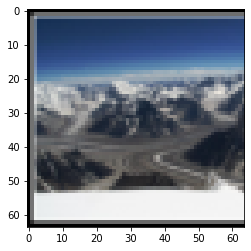

In [7]:
#Using code from last week's biweekly report to load in the data:
import torchvision.transforms as transforms
#Load the data into python:

#The data is all in separate files, so we will need a way of reading a single jpg, appending it to our running tensor of data, and 
#then reading another file
def loadData(folderName):
    i = 0
    #For more info on how to use progress bar: https://pypi.org/project/progressbar2/
    numImages = len([name for name in os.listdir(folderName)])
    with progressbar.ProgressBar(max_value=numImages) as bar:
        #iterate through each file in a directory, code adapted from: 
        #https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
        for file in os.listdir(folderName):
            if file.endswith(".jpg"):
                #read an image into pytorch: https://discuss.pytorch.org/t/how-to-read-just-one-pic/17434/2
                image = Image.open(os.path.join(folderName, file))
                #Some of these images are huge (1024x1024), so normal cropping would eliminate alot of the image
                #Using resize tries to infer what pixels should be in a smaller resolution so much less information is lost
                transformer = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
                x = transformer(image)
                x.unsqueeze_(0)
                if i == 0:
                    out = torch.zeros(numImages, x.shape[1], 64, 64)
                    out[i,:,:,:] = x[:,:, 0:64, 0:64]
                    i+=1
                else:
                    out[i,:,:,:] = x[:,:, 0:64, 0:64]
                    i+=1
                bar.update(i)
    return out
trainData = loadData("./Data/Landscapes")
print("The shape of the training data is: " + str(trainData.shape))

def showImage(x):
    img = x.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
print("An example image:")
showImage(trainData[0,:,:,:])

You can see that there are these black bars in the above image, let's see if those are consistent across the data set:

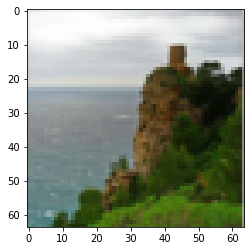

In [8]:
showImage(trainData[1,:,:,:])

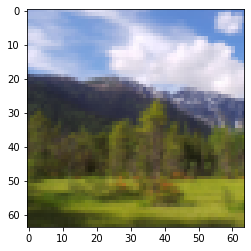

In [9]:
showImage(trainData[2,:,:,:])

In [10]:
#Verify that there is indeed no black bars in the second image
trainData[0,:,0,0] == trainData[2,:,0,0]

tensor([False, False, False])

Let's see how many images do have this strange border out of the total:

In [11]:
count = 0
for i in range(trainData.shape[0]):    
    if (trainData[0,:,0,0] == trainData[i,:,0,0]).numpy().all():
        count+=1
print("The total number of images with this border is: " + str(count))
print("The percentage of the data this represents is: " + str(count/trainData.shape[0]))

The total number of images with this border is: 56
The percentage of the data this represents is: 0.03446153846153846


This is a small enough portion of images that I think we can safely eleminate them from the data so our model is not confused by them.

In [12]:
temp = torch.zeros(trainData.shape[0] - count, trainData.shape[1], trainData.shape[2], trainData.shape[3])
k = 0
for i in range(trainData.shape[0]):
    if (trainData[0,:,0,0] == trainData[i,:,0,0]).numpy().all() != True:
        temp[k,:,:,:] = trainData[i,:,:,:]
        k+=1
trainData = temp
del(temp)

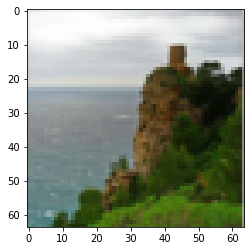

In [13]:
#verify that it worked:
showImage(trainData[0,:,:,:])

Let's now check to see if there are any other strange borders. To have one of these borders we know that all pixels in one of the edge rows of the image will be the same color, testing the rest of the images for this:

In [14]:
count = 0
for i in range(trainData.shape[0]):
    for j in range(4):
        if j == 0:
            temp = trainData[i,:,0,0:trainData.shape[3]]
        elif j == 1:
            temp = trainData[i,:,0:trainData.shape[2],trainData.shape[3]-1]
        elif j == 2:
            temp = trainData[i,:,trainData.shape[2]-1,0:trainData.shape[3]]
        elif j == 3:
            temp = trainData[i,:,0:trainData.shape[2],0]
        flag = True
        for k in range(trainData.shape[3]):
            if (temp[:,0] == temp[:,k]).numpy().all() != True:
                flag = False
                break
        if flag:
            count+=1
            break
print("Number of images with other borders: " + str(count))
print("Percentage of the data that this represents: " + str(count/trainData.shape[0]))

Number of images with other borders: 49
Percentage of the data that this represents: 0.03123008285532186


Again, I think it is fine to remove these images since it looks like they represent only a small portion of the data:

In [15]:
newData = torch.zeros(trainData.shape[0] - count, trainData.shape[1], trainData.shape[2], trainData.shape[3])
l = 0
print("Old shape of the data: " + str(trainData.shape))
for i in range(trainData.shape[0]):
    for j in range(4):
        if j == 0:
            temp = trainData[i,:,0,0:trainData.shape[3]]
        elif j == 1:
            temp = trainData[i,:,0:trainData.shape[2],trainData.shape[3]-1]
        elif j == 2:
            temp = trainData[i,:,trainData.shape[2]-1,0:trainData.shape[3]]
        elif j == 3:
            temp = trainData[i,:,0:trainData.shape[2],0]
        flag = True
        for k in range(trainData.shape[3]):
            if (temp[:,0] == temp[:,k]).numpy().all() != True:
                flag = False
                break
        if flag:
            break
        if flag == False and j == 3:
            newData[l,:,:,:] = trainData[i,:,:,:]
            l+=1
            break
trainData = newData
del(newData)
print("New shape of the Data: " + str(trainData.shape))

Old shape of the data: torch.Size([1569, 3, 64, 64])
New shape of the Data: torch.Size([1520, 3, 64, 64])


Now, I'd like to look at the distribution in color channels again since we should see a wide variety of color intensities since we are hoping that these landscapes are at different times in the day:

Histogram of Colors in the Template Images:


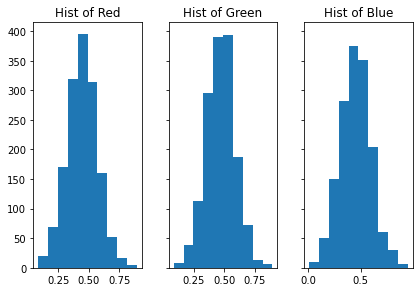

In [16]:
#Using code from last week
def colorHist(x):
    #keep track of average values for RGB channels
    R = []
    G = []
    B = []
    for i in range(3):
        temp = []
        for j in range(x.shape[0]):
            temp.append(torch.mean(x[j,i,:,:]))
        if i == 0:
            R = np.array(temp)
        elif i == 1:
            G = np.array(temp)
        else:
            B = np.array(temp)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,sharey=True)
    fig.tight_layout() 
    
    ax1.hist(R)
    ax1.set_title("Hist of Red")
    ax2.hist(G)
    ax2.set_title("Hist of Green")
    ax3.hist(B)
    ax3.set_title("Hist of Blue")
    #fig.show()
print("Histogram of Colors in the Template Images:")
colorHist(trainData)

Each of these looks normally distibuted around .5, which means we have a normal distribution across all posible intensity values. This most likely means that we have a good spread of time throughout the day, though without manually identifying times it is impossible to know for sure. I am a little concerned about images close to zero, so let's see what one might look like:

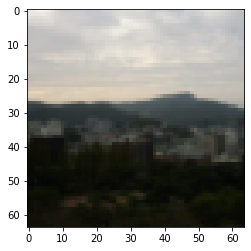

In [17]:
for i in range(3):
    for j in range(trainData.shape[0]):
        temp=torch.mean(trainData[j,i,:,:])
        if temp < .01:
            image = j
showImage(trainData[j,:,:,:])

This actually looks fine. The last thing I want to verify is that there are no invalid pixel values in the data:


In [18]:
for i in range(trainData.shape[0]):
    if torch.sum(torch.isnan(trainData[i,:,:,:])) > 0:
        print("Nan found at: " + str(i))

From my perspective this EDA is sufficient, and we can now move on to the training loop:
### The Training Loop
I made this a new section almost wholly to explain a problem that has persisted despite my best efforts to solve it. Occasionally, the net produces Nans in the back propagation, which is certainly a problem because the whole image produced won't make sense. I've chosen a random seed to try and mitigate this problem, though to reproduce the problem one can simply change the seed to 0 (replace torch.manual_seed(35) with torch.manual_seed(0)). Let me now detail what I have done to try and isolate and solve this problem my first thought was that this was a problem somewhere in the neural net itself (given that it seemed to crop up first in the gradients). Using hooks (a pytorch method which will run a snip of code whenever a tensor is manipulated either in the forward or backward pass (see https://towardsdatascience.com/the-one-pytorch-trick-which-you-should-know-2d5e9c1da2ca for details) I eventually found the the first layer that would produce nans would be the final layer of E_s (the first layer in that the backward pass will manipulate). This left a couple of options for where the problem could be, but my suspicion was that it was a problem with my AdaIn connection (since E_s's final layer is directly connected to that) so I went hunting for problems in my AdaIn method. First however, I made sure that AdaIn was actually the problem (by removing those connections entirely from the generator and instead just concatenating the saved layers without accounting for style), which produced no nans in over 1000 tries (I ran a simple for loop over the code below with max epochs set to 1 since it seemed that nans are most often produced either in the first back prop step or not at all). This led me to believe that I had implemented AdaIn wrong, but this turned out to not be the case, because I tried using an implementation of AdaIn online (found here: https://github.com/naoto0804/pytorch-AdaIN/blob/master/function.py) and this produced the same problem (so I reverted it back to my code). This left me with two more ideas: it could be a problematic image that, if the neural net saw it in the first batch, then it would produce a nan due to some strange structure in the image. This turned out not to be the case either, because looking at the images in the batches involved with this problem did not look qualitatively strange, nor was there a sort of "common image" that was found in all (or many) of the problematic batches. This led me to my final thought which is that the authors of the paper are probably using a non-standard initialization method which avoids this problem. This would explain why setting a random seed seems to fix the problem, and the best explanation I can give is that for a certain range of network initialization parameters the backprop through AdaIn will be required to divide by zero, which will produce the nans. Given time constraints I don't think I'll be able to fix this particular issue, and since I've already spent ample time on this section of the report I think it is reasonable to simply use a valid random seed just so I can move on to new things. The primary goal of this project, at least for me, was to learn all of the cool parts of this implementation, and since I believe that I mostly have a good grasp of what is happening otherwise I believe I can move past this (especially since the net does seem to be working if nans are not produced):

In [19]:
torch.manual_seed(35)
#------------
#To start, we need a style and conent encoder along with optimizers for each
#------------
ec = E_c(3, 64).cuda()
es = E_s(3, 64).cuda()
esPrime = E_s(3, 64).cuda()

ec_opt = torch.optim.Adam(ec.parameters(), betas=(0.5, 0.999))
es_opt = torch.optim.Adam(es.parameters(), betas=(0.5, 0.999))
#------------
#Now, we'll need to define the generator:
#------------
gen = Generator(3,64).cuda()

gen_opt = torch.optim.Adam(gen.parameters(), betas=(0.5, 0.999))
#------------
#Next is the two discriminators, one conditional and the other not conditional
#------------
cDis = Discriminator(3,64, 64).cuda()
nDis = Discriminator(3,64, 64).cuda()
nDis.setConditional(False)
cDis_opt = torch.optim.Adam(cDis.parameters(), betas=(0.5, 0.999), lr = .00001)

nDis_opt = torch.optim.Adam(nDis.parameters(), betas=(0.5, 0.999), lr = .00001)
#------------
L1 = nn.L1Loss()
L2 = nn.MSELoss()

#Function that makes the grads on all the optimizers zero
def zeroOpts():
    ec_opt.zero_grad()
    es_opt.zero_grad()
    gen_opt.zero_grad()
    cDis_opt.zero_grad()
    nDis_opt.zero_grad()
#function that steps all of the optimizers
def stepOpts():
    ec_opt.step()
    es_opt.step()
    cDis_opt.step()
    nDis_opt.step()
    gen_opt.step()
#function that preforms weight clipping (I think this is unused, but it is potentially useful so I'm keeping it in)
def weightClip():
    for j in ec.parameters():
        j.data.clamp_(-.1,.1)
    for j in es.parameters():
        j.data.clamp_(-.1,.1)
    for j in cDis.parameters():
        j.data.clamp_(-.1,.1)
    for j in nDis.parameters():
        j.data.clamp_(-.1,.1)
    for j in gen.parameters():
        j.data.clamp_(-.1,.1)
#preforms grad clipping on all the optimizers
def gradClip():
    torch.nn.utils.clip_grad_norm_(ec.parameters(), .1)
    torch.nn.utils.clip_grad_norm_(es.parameters(), .1)
    torch.nn.utils.clip_grad_norm_(cDis.parameters(), .1)
    torch.nn.utils.clip_grad_norm_(nDis.parameters(), .1)
    torch.nn.utils.clip_grad_norm_(gen.parameters(), .1)
#Initialize a list to keep track the style vectors from prior batches (see CORAL Loss)
listOfPriorStyles = []
T = 10 #max number of prior batches to keep track of
batch_size = 24
num_batches = 100
currentStep = 0 #used for the progress bar

with progressbar.ProgressBar(max_value=num_batches) as bar:
    for i in range(num_batches):
        zeroOpts()
        #------------
        #get images from the data
        #------------
        temp1 = torch.randint(low = 0, high = trainData.shape[0], size = (batch_size,1))
        temp1 = temp1[:,0].numpy()
        x1 = trainData[temp1,:,:,:].view(batch_size,trainData.shape[1],trainData.shape[2], trainData.shape[3]).cuda()
        temp2 = torch.randint(low = 0, high = trainData.shape[0], size = (batch_size,1))
        temp2 = temp2[:,0].numpy()
        x2 = trainData[temp2,:,:,:].view(batch_size,trainData.shape[1],trainData.shape[2], trainData.shape[3]).cuda()

        #------------
        #We will need to train each loss sequentially
        #------------

        #------------
        #First we'll calculate the CORAL Loss:
        #------------
        s = es(x1)[:,:,0,0]
        sPrime = es(x2)[:,:,0,0]
        listOfPriorStyles.append(s)
        listOfPriorStyles.append(sPrime)

        temp = torch.cat(listOfPriorStyles, dim = 0)
        loss = coralLoss(temp)
        loss.backward()
        stepOpts()
        temp = []
        k = 0
        for i in listOfPriorStyles:
            if len(listOfPriorStyles) < T:
                temp.append(i.detach())
            else:
                if k > 1:
                    temp.append(i.detach())
                k+=1
        listOfPriorStyles = temp
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        # Now train the discriminators on real data:
        #------------
        s = es(x1)[:,:,0,0]
        cD = cDis(x1, s)
        nD = nDis(x1, None)
        tar = torch.ones(batch_size,1).cuda()
        loss = 5*(L2(cD, tar) + L2(nD, tar))
        loss.backward()
        gradClip()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        # now train the other model aspects
        #------------
        #First generate a style vector generated from our prior distribution (assumed to be the unit normal)
        s_r = torch.zeros(batch_size,3).cuda()
        for i in range(3):
            for j in range(batch_size):
                s_r[j,i] = torch.normal(mean=0.0, std=torch.arange(1., 2.)).cuda()

        #Now we will extract the content from out first image x1
        c = ec(x1)

        #Get the generated image
        gen.setSavedLayers(ec.getSavedLayers())
        g = gen(c,s_r)

        #Run g through ec and es to get the reconstructed style and content codes
        c_rec = ec(g)
        s_rec = es(g)[:,:,0,0]

        #Calculate the loss associated with this step
        l1_rLoss = 10*L1(s_rec, s_r) + L1(c_rec, c)

        #Run reconstructed codes through the generator and find the reconstruction/advisarial losses
        gen.setSavedLayers(ec.getSavedLayers())
        g2 = gen(c_rec, s_rec)
        #Find the discriminator outputs
        cD = cDis(g2, s_rec)
        nD = nDis(g2, None)
        tar = torch.zeros(batch_size,1).cuda()
        temp = 2*L1(g2, g)
        loss = 5*(L2(nD,tar) + L2(cD, tar)) + temp + l1_rLoss

        loss.backward()   
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        #Now we will implement the reconstruction loss
        #------------

        #------------
        #Train reconstruction
        #------------
        c = ec(x1)
        s = es(x1)[:,:,0,0]
        gen.setSavedLayers(ec.getSavedLayers())
        g = gen(c,s)
        loss = 10*L1(g,x1)
        #print(loss)
        loss.backward()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        #Style branch, imparting the style s' onto our image:
        #------------

        #------------
        #To start, train the discriminator on real data:
        #------------
        s = es(x1)[:,:,0,0]
        cD = cDis(x1, s)
        nD = nDis(x1, None)
        tar = torch.ones(batch_size,1).cuda()
        loss = 5*(L2(cD, tar) + L2(nD, tar))
        loss.backward()
        gradClip()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        #Now, consider the L_cyc loss branch
        #------------

        #Now we need the style that we will use for the final generator step
        s_temp = es(x1)[:,:,0,0]
        c_temp = ec(x2)
        gen.setSavedLayers(ec.getSavedLayers())
        g2 = gen(c_temp, s_temp)
        s_hat = es(g2)[:,:,0,0]

        torch.cuda.empty_cache()
        s_star = es(x2)[:,:,0,0]
        c = ec(x1)
        gen.setSavedLayers(ec.getSavedLayers())
        g = gen(c, s_star)

        #Run g through ec and es to get the reconstructed style and content codes
        c_rec = ec(g)
        s_rec = es(g)[:,:,0,0]
        #Calculate the loss associated with this step
        l1_rLoss = 4*L1(s_rec, s_star) + L1(c_rec, c)

        #get the cyc image
        gen.setSavedLayers(ec.getSavedLayers())
        g_cyc = gen(c_rec, s_hat)

        #Run this through the discriminators:
        cD = cDis(g_cyc, s_hat)
        nD = nDis(g_cyc, None)
        tar = torch.zeros(batch_size,1).cuda()
        #calculate the loss:
        loss = 2*L1(g_cyc, x1) + 5*(L2(nD,tar) + L2(cD, tar)) + l1_rLoss
        loss.backward()
        gradClip()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()
        
        #---------------------------------------------------------------------------------------------
        #Training the symmetric part of the net:
        #---------------------------------------------------------------------------------------------
        
        #------------
        #First we'll calculate the CORAL Loss:
        #------------
        s = es(x2)[:,:,0,0]
        
        sPrime = es(x1)[:,:,0,0]
        listOfPriorStyles.append(s)
        listOfPriorStyles.append(sPrime)

        temp = torch.cat(listOfPriorStyles, dim = 0)
        loss = coralLoss(temp)
        loss.backward()
        stepOpts()
        temp = []
        k = 0
        for i in listOfPriorStyles:
            if len(listOfPriorStyles) < T:
                temp.append(i.detach())
            else:
                if k > 1:
                    temp.append(i.detach())
                k+=1
        listOfPriorStyles = temp
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        # Now train the discriminators on real data:
        #------------
        s = es(x2)[:,:,0,0]
        cD = cDis(x2, s)
        nD = nDis(x2, None)
        tar = torch.ones(batch_size,1).cuda()
        loss = 5*(L2(cD, tar) + L2(nD, tar))
        loss.backward()
        gradClip()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        # now train the other model aspects
        #------------
        #First generate a style vector generated from our prior distribution (assumed to be the unit normal)
        s_r = torch.zeros(batch_size,3).cuda()
        for i in range(3):
            for j in range(batch_size):
                s_r[j,i] = torch.normal(mean=0.0, std=torch.arange(1., 2.)).cuda()

        #Now we will extract the content from out first image x2
        c = ec(x2)

        #Get the generated image
        gen.setSavedLayers(ec.getSavedLayers())
        g = gen(c,s_r)

        #Run g through ec and es to get the reconstructed style and content codes
        c_rec = ec(g)
        s_rec = es(g)[:,:,0,0]

        #Calculate the loss associated with this step
        l1_rLoss = 10*L1(s_rec, s_r) + L1(c_rec, c)

        #Run reconstructed codes through the generator and find the reconstruction/advisarial losses
        gen.setSavedLayers(ec.getSavedLayers())
        g2 = gen(c_rec, s_rec)
        #Find the discriminator outputs
        cD = cDis(g2, s_rec)
        nD = nDis(g2, None)
        tar = torch.zeros(batch_size,1).cuda()
        temp = 2*L1(g2, g)
        loss = 5*(L2(nD,tar) + L2(cD, tar)) + temp + l1_rLoss

        loss.backward()   
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        #Now we will implement the reconstruction loss
        #------------

        #------------
        #Train reconstruction
        #------------
        c = ec(x2)
        s = es(x2)[:,:,0,0]
        gen.setSavedLayers(ec.getSavedLayers())
        g = gen(c,s)
        loss = 10*L1(g,x2)
        #print(loss)
        loss.backward()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        #Style branch, imparting the style s' onto our image:
        #------------

        #------------
        #To start, train the discriminator on real data:
        #------------
        s = es(x2)[:,:,0,0]
        cD = cDis(x2, s)
        nD = nDis(x2, None)
        tar = torch.ones(batch_size,1).cuda()
        loss = 5*(L2(cD, tar) + L2(nD, tar))
        loss.backward()
        gradClip()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()

        #------------
        #Now, consider the L_cyc loss branch
        #------------

        #Now we need the style that we will use for the final generator step
        s_temp = es(x2)[:,:,0,0]
        c_temp = ec(x1)
        gen.setSavedLayers(ec.getSavedLayers())
        g2 = gen(c_temp, s_temp)
        s_hat = es(g2)[:,:,0,0]

        torch.cuda.empty_cache()
        s_star = es(x1)[:,:,0,0]
        c = ec(x2)
        gen.setSavedLayers(ec.getSavedLayers())
        g = gen(c, s_star)

        #Run g through ec and es to get the reconstructed style and content codes
        c_rec = ec(g)
        s_rec = es(g)[:,:,0,0]

        #Calculate the loss associated with this step
        l1_rLoss = 4*L1(s_rec, s_star) + L1(c_rec, c)

        #get the cyc image
        gen.setSavedLayers(ec.getSavedLayers())
        g_cyc = gen(c_rec, s_hat)

        #Run this through the discriminators:
        cD = cDis(g_cyc, s_hat)
        nD = nDis(g_cyc, None)
        tar = torch.zeros(batch_size,1).cuda()
        #calculate the loss:
        loss = 2*L1(g_cyc, x2) + 5*(L2(nD,tar) + L2(cD, tar)) + l1_rLoss
        loss.backward()
        gradClip()
        stepOpts()
        zeroOpts()
        torch.cuda.empty_cache()
        #print(loss)
        if torch.isnan(loss):
            print("Something went wrong, exiting....")
            print("Minibatch number: " + str(currentStep))
            print(temp1)
            print(temp2)
            break
        currentStep+=1
        bar.update(currentStep)

 55% (55 of 100) |############           | Elapsed Time: 0:03:01 ETA:   0:02:36


KeyboardInterrupt: 

The content image


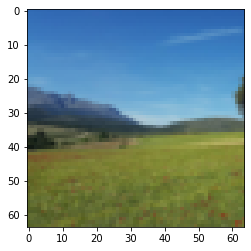

In [71]:
print("The content image")
showImage(x2[0,:,:,:])

The style image


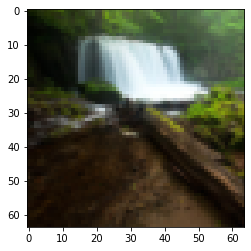

In [72]:
print("The style image")
showImage(x1[0,:,:,:])

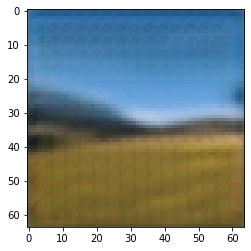

In [70]:
showImage(g_cyc[0,:,:,:])

This does look qualitatively different, though it is not clear to me if this is a different time of day or not. It's worth noting that I did try to train this network for longer, but it looks like the content is lost after a certain point because this is a multi objective optimization problem, and the generator eventually figures out that it can optimize some of the other objectives by simplifying the image itself. My suspicion is that we would eventually get the content again (when the model had learned everything it could about the other objectives and would then be forced to minimize the content loss again), but judging by how long the authors had to train their network this probably wouldn't happen for a very long time for me.
### Final Thoughts
Overall, this did work and I learned a lot in the process of doing it. That being said, it didn't work without a hitch (namely the fact that it occasionally produces Nans), but since I think understanding the concepts was really what I wanted from this project I don't think that this problem was that bad. I think my main takeaways from this project was how summary statistics can be used to encode information about images, and how we can exploit these properties to get certain behaviors from GANs. I also think that projection GANs will be a useful addition to my toolkit for future projects, in fact I would like to go back to my simple GAN from my first biweekly report to see how a projection GAN might allow us to conditionally generate digits (see ProjectionGANOnMNIST.ipynb). While it is not clear to me if the time of day is actually being imparted on the final image, it does look different in style without losing the content, so that is good. There is many potential reasons for my results being less good than the paper's (from training time to subtle differences in my neural net's setup), but given that these results are fine for the time being I am satisfied with calling this project complete (rather than sifting through the large amount of source code released by the authors of the paper to find exactly what they did). 